### Set up

In [1]:
!pip install torch==2.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
import keras
import torch

In [3]:
import sys
sys.path.append(sys.path.append('drive/My Drive/CURIS/VeriX/'))

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
saved_data_path = 'drive/MyDrive/CURIS/VeriX/saved_data/'
output_path = 'drive/MyDrive/CURIS/VeriX/outputs/'

In [6]:
normal_results = pd.read_pickle(saved_data_path + "normal_results.pkl")
normal_results_1000 = pd.read_pickle(saved_data_path + "normal_results_1000.pkl")
ood_letters_results = pd.read_pickle(saved_data_path + "ood_letters_results.pkl")
ood_cifar_results = pd.read_pickle(saved_data_path + "ood_cifar_results.pkl")

function defs

In [7]:
def softmax(logits):
  return np.exp(np.max(logits, axis=1)) / np.sum(np.exp(logits), axis=1)

In [8]:
def plot_ece_bins(logits, labels, n_bins=10):

  confidences = softmax(logits)
  preds = np.argmax(logits, axis=1)
  correct_preds = np.equal(preds, labels)

  bin_boundaries = np.linspace(0, 1, n_bins + 1)
  bin_accuracies = []
  bin_confidences = []
  for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:]):
    elems_acc = correct_preds[(confidences > lower) & (confidences <= upper)]
    elems_confidences = confidences[(confidences > lower) & (confidences <= upper)]
    num_in_bin = elems_acc.size()[0]
    num_correct = torch.sum(elems_acc).item()
    accuracy = num_correct / num_in_bin if num_in_bin > 2 else 0
    confidence = np.mean(elems_confidences) if num_in_bin > 2 else 0
    bin_accuracies.append(accuracy)
    bin_confidences.append(confidence)

  plt.bar(np.arange(n_bins) / n_bins, bin_accuracies, width=1/n_bins, edgecolor='black', align='edge')
  plt.xlim(0, 1)
  plt.ylim(0, 1)
  plt.gca().set_aspect('equal', adjustable='box')
  plt.plot([1, 0], [1, 0], color='red', linestyle='--')

Convert model from keras to pytorch so it can be used with the existing temp scaling code

In [9]:
keras_model = keras.models.load_model('drive/MyDrive/CURIS/VeriX/networks/mnist-10x2-normal.h5')
weights=keras_model.get_weights()

In [10]:
from networks.torch_networks import FullyConnectedNetwork
torch_model = FullyConnectedNetwork(784, 10, 10) # torch network with the same architecture

In [11]:
# copy over weights
torch_model.fc1.weight.data=torch.from_numpy(np.transpose(weights[0]))
torch_model.fc1.bias.data=torch.from_numpy(weights[1])
torch_model.fc2.weight.data=torch.from_numpy(np.transpose(weights[2]))
torch_model.fc2.bias.data=torch.from_numpy(weights[3])
torch_model.output_layer.weight.data=torch.from_numpy(np.transpose(weights[4]))
torch_model.output_layer.bias.data=torch.from_numpy(np.transpose(weights[5]))

Compare predictions of the two models to make sure outputs are the same. Very small differences in logit values, probably because of truncation error.

In [12]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

11490434/11490434 [==============================] - 0s 0us/step


In [13]:
# keras_logits = keras_model.predict(x_test)

In [14]:
x_test_tensor = torch.tensor(x_test.reshape(x_test.shape[0],-1))
y_test_tensor = torch.tensor(np.argmax(y_test, axis=1))
torch_logits = torch_model.forward(x_test_tensor)

In [15]:
# sum(abs(keras_logits - torch_logits.detach().numpy()))

### Temp scaling

Test existing temperature scaleling method

In [16]:
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create a DataLoader
batch_size = 64  # Set your desired batch size
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True,
                             sampler=SubsetRandomSampler(range(x_test.shape[0])))

In [17]:
# from temperature_scaling.temperature_scaling import ModelWithTemperature

# temp_scaled_model = ModelWithTemperature(torch_model)
# temp_scaled_model.set_temperature(test_dataloader, 1000)

Scale with explanation sizes

In [18]:
import os

In [19]:
# # read explanation sizes
# output_path = 'drive/MyDrive/CURIS/VeriX/outputs/mnist-10x2-normal/'
NUM_VAL = 300
NUM_TEST = 700
# normal_explanation_sizes = np.zeros(NUM_VAL + NUM_TEST)
# for i in range(NUM_VAL):
#   pth = f'{output_path}index-{i}-mnist-10x2-normal-60s-heuristic-linf0.05'
#   if os.path.exists(pth):
#     files = os.listdir(pth)
#     explanation_files = [f for f in files if "explanation" in f.lower()]
#     if explanation_files:
#         explanation_file = explanation_files[0]
#         _, explanation_size = explanation_file[:-4].split("explanation-", 1)
#         normal_explanation_sizes[i] = int(explanation_size)
#     else:
#         print(f"Warning: explanation not found for index {i}")
# normal_explanation_sizes /= 28 * 28
# normal_explanation_sizes = torch.tensor(normal_explanation_sizes)
# normal_explanation_sizes_val = normal_explanation_sizes[:NUM_VAL]
# normal_explanation_sizes_test = normal_explanation_sizes[NUM_VAL:]

In [20]:
normal_explanation_sizes = np.array(28 * 28 - normal_results_1000['unsat_size'], dtype='float64')
normal_explanation_sizes /= 28 * 28
normal_explanation_sizes = torch.tensor(normal_explanation_sizes)
normal_explanation_sizes_val = normal_explanation_sizes[:NUM_VAL]
normal_explanation_sizes_test = normal_explanation_sizes[NUM_VAL:]

In [21]:
normal_explanation_sizes_test.shape

torch.Size([700])

In [22]:
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

x_val = x_test_tensor[:NUM_VAL, :]
y_val = y_test_tensor[:NUM_VAL]
x_test = x_test_tensor[NUM_VAL: NUM_VAL + NUM_TEST, :]
y_test = y_test_tensor[NUM_VAL:NUM_VAL + NUM_TEST]
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

# Create a DataLoader
batch_size = 64  # Set your desired batch size
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True,
                             sampler=SubsetRandomSampler(range(NUM_VAL)))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True,
                             sampler=SubsetRandomSampler(range(NUM_TEST)))

In [23]:
from verix_temperature_scaling.temperature_scaling import ModelWithTemperature

temp_scaled_model = ModelWithTemperature(torch_model)
temp_scaled_model.set_temperature(val_dataloader, 1000)


Before temperature - NLL: 0.165, ECE: 0.033
Optimal temperature: 0.940
After temperature - NLL: 0.164, ECE: 0.027


(ModelWithTemperature(
   (model): FullyConnectedNetwork(
     (fc1): Linear(in_features=784, out_features=10, bias=True)
     (relu1): ReLU()
     (fc2): Linear(in_features=10, out_features=10, bias=True)
     (relu2): ReLU()
     (output_layer): Linear(in_features=10, out_features=10, bias=True)
   )
 ),
 0.16491179168224335,
 0.03300975635647774,
 0.1635637730360031,
 0.026656141504645348)

In [24]:
from verix_temperature_scaling.verix_temperature_scaling import ModelWithVeriXTemperature

print('softmax(logits / (T * (1 + explanation_size / 784))')
verix_temp_scaled_model = ModelWithVeriXTemperature(torch_model, 'original')
verix_temp_scaled_model.set_temperature(val_dataloader, normal_explanation_sizes_val, 1000)
# print('\nsoftmax(logits / (T * ((1 + 784 / explanation_size))')
# verix_temp_scaled_model_inverse = ModelWithVeriXTemperature(torch_model, 'inverse')
# verix_temp_scaled_model_inverse.set_temperature(val_dataloader, normal_explanation_sizes, 1000)
print('\nsoftmax(logits / (T * (1 + (explanation_size / 784) ** 2))')
verix_temp_scaled_model_squared = ModelWithVeriXTemperature(torch_model, 'square')
verix_temp_scaled_model_squared.set_temperature(val_dataloader, normal_explanation_sizes_val, 1000)
print('\nsoftmax(logits / (T * (1 + (explanation_size / 784)) ** 2)')
verix_temp_scaled_model_squared2 = ModelWithVeriXTemperature(torch_model, 'square')
verix_temp_scaled_model_squared2.set_temperature(val_dataloader, normal_explanation_sizes_val, 1000)

# verix_temp_scaled_model.test(test_dataloader)

softmax(logits / (T * (1 + explanation_size / 784))
Before temperature - NLL: 0.165, ECE: 0.033
Optimal temperature: 0.805
After temperature - NLL: 0.167, ECE: 0.026

softmax(logits / (T * (1 + (explanation_size / 784) ** 2))
Before temperature - NLL: 0.165, ECE: 0.033
Optimal temperature: 0.890
After temperature - NLL: 0.165, ECE: 0.036

softmax(logits / (T * (1 + (explanation_size / 784)) ** 2)
Before temperature - NLL: 0.165, ECE: 0.033
Optimal temperature: 0.874
After temperature - NLL: 0.158, ECE: 0.024


(ModelWithVeriXTemperature(
   (model): FullyConnectedNetwork(
     (fc1): Linear(in_features=784, out_features=10, bias=True)
     (relu1): ReLU()
     (fc2): Linear(in_features=10, out_features=10, bias=True)
     (relu2): ReLU()
     (output_layer): Linear(in_features=10, out_features=10, bias=True)
   )
 ),
 0.16491183638572693,
 0.03300975635647774,
 0.1576979931449509,
 0.024237975478172302)

In [25]:
from verix_temperature_scaling.verix_temperature_scaling_weighted import ModelWithVeriXTemperatureWeighted

print('softmax(logits / (T * (1 + W * explanation_size / 784))')
verix_temp_scaled_weighted_model = ModelWithVeriXTemperatureWeighted(torch_model, 'original')
verix_temp_scaled_weighted_model.set_temperature(val_dataloader, normal_explanation_sizes_val, 1000)
print('\nsoftmax(logits / (T * (1 + (W * explanation_size / 784) ** 2))')
verix_temp_scaled_model_weighted_squared = ModelWithVeriXTemperatureWeighted(torch_model, 'square')
verix_temp_scaled_model_weighted_squared.set_temperature(val_dataloader, normal_explanation_sizes_val, 1000)
print('\nsoftmax(logits / (T * (1 + (W * explanation_size / 784)) ** 2)')
verix_temp_scaled_model_weighted_squared2 = ModelWithVeriXTemperatureWeighted(torch_model, 'square')
verix_temp_scaled_model_weighted_squared2.set_temperature(val_dataloader, normal_explanation_sizes_val, 1000)

softmax(logits / (T * (1 + W * explanation_size / 784))
Before temperature - NLL: 0.165, ECE: 0.033
Optimal temperature: 1.000
Optimal exp size weight: 0.973
After temperature - NLL: 0.181, ECE: 0.046

softmax(logits / (T * (1 + (W * explanation_size / 784) ** 2))
Before temperature - NLL: 0.165, ECE: 0.033
Optimal temperature: 1.000
Optimal exp size weight: 0.994
After temperature - NLL: 0.169, ECE: 0.036

softmax(logits / (T * (1 + (W * explanation_size / 784)) ** 2)
Before temperature - NLL: 0.165, ECE: 0.033
Optimal temperature: 1.000
Optimal exp size weight: 0.995
After temperature - NLL: 0.168, ECE: 0.037


ModelWithVeriXTemperatureWeighted(
  (model): FullyConnectedNetwork(
    (fc1): Linear(in_features=784, out_features=10, bias=True)
    (relu1): ReLU()
    (fc2): Linear(in_features=10, out_features=10, bias=True)
    (relu2): ReLU()
    (output_layer): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [26]:
print("\ntemp scaled:")
temp_scaled_model.test(test_dataloader)
print("\nverix temp scaled:")
verix_temp_scaled_model.test(test_dataloader, normal_explanation_sizes_test)
verix_temp_scaled_model_squared2.test(test_dataloader, normal_explanation_sizes_test)
verix_temp_scaled_weighted_model.test(test_dataloader, normal_explanation_sizes_test)
verix_temp_scaled_model_weighted_squared.test(test_dataloader, normal_explanation_sizes_test)
verix_temp_scaled_model_weighted_squared2.test(test_dataloader, normal_explanation_sizes_test)


temp scaled:
Testing
Before temperature - NLL: 0.239, ECE: 0.018
Optimal temperature: 0.940
After temperature - NLL: 0.241, ECE: 0.016

verix temp scaled:
Testing
Before temperature - NLL: 0.239, ECE: 0.018
Temperature: 0.805
After temperature - NLL: 0.240, ECE: 0.013
Testing
Before temperature - NLL: 0.239, ECE: 0.018
Temperature: 0.874
After temperature - NLL: 0.247, ECE: 0.018
Testing
Before temperature - NLL: 0.239, ECE: 0.018
Temperature: 1.000
Exp size weight: 0.973
After temperature - NLL: 0.254, ECE: 0.037
Testing
Before temperature - NLL: 0.239, ECE: 0.018
Temperature: 1.000
Exp size weight: 0.994
After temperature - NLL: 0.238, ECE: 0.028
Testing
Before temperature - NLL: 0.239, ECE: 0.018
Temperature: 1.000
Exp size weight: 0.995
After temperature - NLL: 0.243, ECE: 0.028


tensor([[ -7.0579,   5.7709,  -1.5644,  ...,  -0.0331,  -1.5217,  -2.3906],
        [ -8.5273,   7.4083,  -2.3011,  ...,  -1.5550,  -0.5873,  -3.3049],
        [ -0.2074, -11.7731,  -1.5455,  ...,  -9.8372,   1.6270,  -5.5495],
        ...,
        [ -7.1529,   5.7878,  -1.1015,  ...,  -4.8696,   0.0469,  -4.2185],
        [ -4.0757, -15.0296,  -6.9525,  ..., -11.7300,   2.6575,  -1.5896],
        [ -3.7408,  -2.4765,  -1.0947,  ...,   2.4341,  -0.7261,   0.1867]],
       device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)

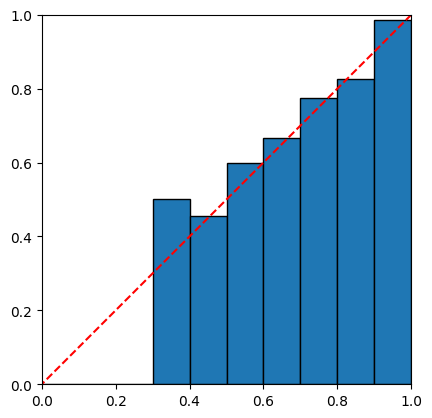

In [27]:
normal_logits = torch_model(x_test.cuda())
plot_ece_bins(normal_logits.cpu().detach().numpy(), y_test)

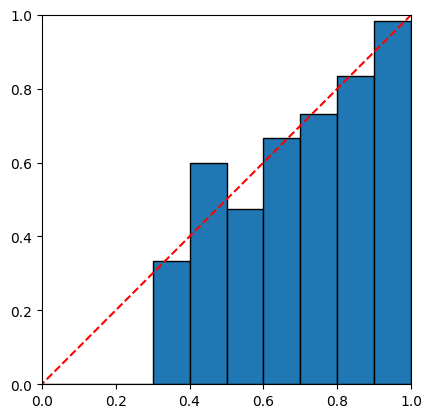

In [28]:
temp_scaled_model_normal_logits = temp_scaled_model(x_test.cuda())
plot_ece_bins(temp_scaled_model_normal_logits.cpu().detach().numpy(), y_test)

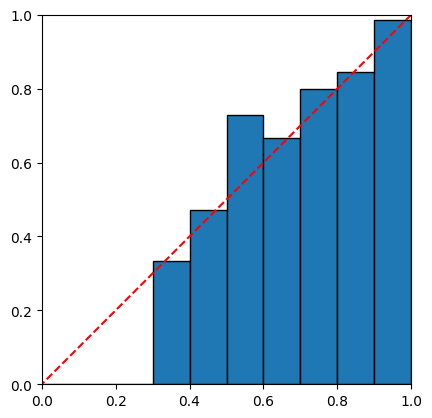

In [29]:
verix_temp_scaled_model_normal_logits = verix_temp_scaled_model_squared2(x_test.cuda(), normal_explanation_sizes_test.cuda())
plot_ece_bins(verix_temp_scaled_model_normal_logits.cpu().detach().numpy(), y_test)

Test on indices 300:999 (not used for training)

In [30]:
normal_results_1000

,index,sat_size,timeout_size,unsat_size,sat_set,timeout_set,unsat_set
0,0,210,0,574,"[662, 553, 277, 33, 232, 687, 465, 481, 432, 5...",[],"[530, 338, 336, 366, 773, 308, 253, 734, 310, ..."
1,1,290,0,494,"[704, 683, 134, 154, 629, 632, 554, 152, 354, ...",[],"[418, 446, 475, 531, 503, 474, 447, 697, 558, ..."
2,2,216,1,567,"[490, 535, 283, 328, 31, 572, 407, 773, 111, 2...",[51],"[114, 253, 250, 586, 558, 278, 335, 530, 708, ..."
3,3,65,0,719,"[352, 75, 322, 66, 380, 298, 441, 507, 629, 62...",[],"[647, 614, 44, 40, 444, 565, 39, 165, 561, 416..."
4,4,226,0,558,"[257, 236, 736, 231, 627, 438, 214, 246, 289, ...",[],"[396, 135, 397, 423, 422, 732, 172, 703, 774, ..."
...,...,...,...,...,...,...,...
995,995,3,0,781,"[248, 277, 334]",[],"[418, 446, 697, 474, 475, 531, 447, 391, 419, ..."
996,996,59,0,725,"[422, 674, 675, 42, 718, 104, 90, 192, 713, 25...",[],"[418, 446, 475, 531, 474, 447, 697, 391, 419, ..."
997,997,54,0,730,"[96, 100, 769, 137, 115, 393, 74, 363, 724, 64...",[],"[561, 612, 501, 740, 59, 666, 640, 694, 614, 6..."
998,998,69,0,715,"[352, 725, 602, 703, 535, 607, 135, 469, 698, ...",[],"[667, 639, 249, 695, 277, 251, 250, 248, 360, ..."


#### more experiments

In [ ]:
import random

results = pd.DataFrame(columns=['Run', 'Before ECE', 'Temp Scaled ECE', 'Temp Scaled Test ECE','VeriX ECE', 'VeriX Test ECE', 'Squared ECE', 'Squared Test ECE', 'Squared2 ECE', 'Squared2 Test ECE'])

for i in range(20):
  print("\n------------")
  print(f"Run {i}")
  indices = list(range(normal_explanation_sizes.shape[0]))
  random.shuffle(indices)
  x_val = x_test_tensor[indices[:NUM_VAL], :]
  x_test = x_test_tensor[indices[NUM_VAL: NUM_VAL + NUM_TEST], :]
  y_val = y_test_tensor[indices[:NUM_VAL]]
  y_test = y_test_tensor[indices[NUM_VAL: NUM_VAL + NUM_TEST]]

  normal_explanation_sizes_val = normal_explanation_sizes[indices[:NUM_VAL]]
  normal_explanation_sizes_test = normal_explanation_sizes[indices[NUM_VAL: NUM_VAL + NUM_TEST]]

  val_dataset = TensorDataset(x_val, y_val)
  test_dataset = TensorDataset(x_test, y_test)

  batch_size = 64
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True,
                              sampler=SubsetRandomSampler(range(NUM_VAL)))
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True,
                              sampler=SubsetRandomSampler(range(NUM_TEST)))

  print('\noriginal temp scaling')
  temp_scaled_model = ModelWithTemperature(torch_model)
  _, before_nll, before_ece, temp_after_nll, temp_after_ece = temp_scaled_model.set_temperature(val_dataloader, 1000)
  _, temp_test_nll, temp_test_ece = temp_scaled_model.test(test_dataloader)

  print('\nsoftmax(logits / (T * (1 + explanation_size / 784))')
  verix_temp_scaled_model = ModelWithVeriXTemperature(torch_model, 'original')
  _, _, _, verix_after_nll, verix_after_ece = verix_temp_scaled_model.set_temperature(val_dataloader, normal_explanation_sizes_val, 1000)
  _, verix_test_nll, verix_test_ece = verix_temp_scaled_model.test(test_dataloader, normal_explanation_sizes_test)

  print('\nsoftmax(logits / (T * (1 + (explanation_size / 784) ** 2))')
  verix_temp_scaled_model_squared = ModelWithVeriXTemperature(torch_model, 'square')
  _, _, _, squared_after_nll, squared_after_ece = verix_temp_scaled_model_squared.set_temperature(val_dataloader, normal_explanation_sizes_val, 1000)
  _, squared_test_nll, squared_test_ece = verix_temp_scaled_model_squared.test(test_dataloader, normal_explanation_sizes_test)

  print('\nsoftmax(logits / (T * (1 + (explanation_size / 784)) ** 2)')
  verix_temp_scaled_model_squared2 = ModelWithVeriXTemperature(torch_model, 'square')
  _, _, _, squared2_after_nll, squared2_after_ece = verix_temp_scaled_model_squared2.set_temperature(val_dataloader, normal_explanation_sizes_val, 1000)
  _, squared2_test_nll, squared2_test_ece = verix_temp_scaled_model_squared2.test(test_dataloader, normal_explanation_sizes_test)

  results.loc[i] = [i, before_ece, temp_after_ece, temp_test_ece, verix_after_ece, verix_test_ece, squared_after_ece, squared_test_ece, squared2_after_ece, squared2_test_ece]



------------
Run 0

original temp scaling
Before temperature - NLL: 0.243, ECE: 0.031
Optimal temperature: 1.043
After temperature - NLL: 0.242, ECE: 0.036
Testing
Before temperature - NLL: 0.206, ECE: 0.021
Optimal temperature: 1.043
After temperature - NLL: 0.207, ECE: 0.021

softmax(logits / (T * (1 + explanation_size / 784))
Before temperature - NLL: 0.243, ECE: 0.031
Optimal temperature: 0.904
After temperature - NLL: 0.245, ECE: 0.035
Testing
Before temperature - NLL: 0.206, ECE: 0.021
Temperature: 0.904
After temperature - NLL: 0.216, ECE: 0.031

softmax(logits / (T * (1 + (explanation_size / 784) ** 2))
Before temperature - NLL: 0.243, ECE: 0.031
Optimal temperature: 0.994
After temperature - NLL: 0.244, ECE: 0.042
Testing
Before temperature - NLL: 0.206, ECE: 0.021
Temperature: 0.994
After temperature - NLL: 0.211, ECE: 0.026

softmax(logits / (T * (1 + (explanation_size / 784)) ** 2)
Before temperature - NLL: 0.243, ECE: 0.031
Optimal temperature: 0.996
After temperature - N

In [ ]:
results

,Run,Before ECE,Temp Scaled ECE,Temp Scaled Test ECE,VeriX ECE,VeriX Test ECE,Squared ECE,Squared Test ECE,Squared2 ECE,Squared2 Test ECE
0,0.0,0.031193,0.035860,0.020854,0.034603,0.030814,0.042376,0.026077,0.043950,0.026545
1,1.0,0.032146,0.019833,0.024660,0.030047,0.027468,0.028763,0.026550,0.025143,0.022220
2,2.0,0.029657,0.019433,0.013090,0.033004,0.019990,0.031564,0.016230,0.025436,0.021432
3,3.0,0.024139,0.019702,0.017654,0.033967,0.014791,0.018797,0.019474,0.015549,0.022137
4,4.0,0.031105,0.037402,0.023737,0.030234,0.016764,0.033831,0.023286,0.030784,0.016536
5,5.0,0.034472,0.034487,0.021341,0.031208,0.028354,0.036221,0.024782,0.033164,0.018675
6,6.0,0.053618,0.053618,0.022434,0.042725,0.026919,0.049392,0.023009,0.055603,0.021998
7,7.0,0.038091,0.037541,0.019958,0.040874,0.030900,0.042214,0.028078,0.042250,0.029455
8,8.0,0.032636,0.032636,0.022260,0.028702,0.024727,0.030660,0.026656,0.030626,0.024158
9,9.0,0.028380,0.027852,0.020561,0.029453,0.015410,0.032019,0.018039,0.024348,0.017713


In [ ]:
results.mean()

Run                     9.500000
Before ECE              0.032094
Temp Scaled ECE         0.030681
Temp Scaled Test ECE    0.022056
VeriX ECE               0.033949
VeriX Test ECE          0.024986
Squared ECE             0.033807
Squared Test ECE        0.023754
Squared2 ECE            0.032738
Squared2 Test ECE       0.022518
dtype: float64

### Adv samples

Test on adversarial samples

In [ ]:
# load samples
adv_samples_path = 'drive/MyDrive/CURIS/VeriX/adv_samples/'
NUM_PGD_SAMPLES = 100
x_test_pgd = torch.tensor(np.load(adv_samples_path + 'mnist-30x2-normal-pgd-samples.npy'))[:NUM_PGD_SAMPLES]
y_test_pgd = y_test_tensor[:NUM_PGD_SAMPLES]
pgd_test_dataset = TensorDataset(x_test_pgd.view(NUM_PGD_SAMPLES, -1), y_test_pgd)
pgd_test_dataloader = DataLoader(pgd_test_dataset, batch_size=batch_size, pin_memory=True,
                             sampler=SubsetRandomSampler(range(NUM_PGD_SAMPLES)))

In [ ]:
# read explanation sizes
output_path = 'drive/MyDrive/CURIS/VeriX/outputs/mnist-30x2-normal-pgd-samples/mnist-10x2-normal/'
pgd_explanation_sizes = np.zeros(NUM_PGD_SAMPLES)
for i in range(NUM_PGD_SAMPLES):
  pth = f'{output_path}index-{i}-mnist-10x2-normal-60s-heuristic-linf0.05'
  if os.path.exists(pth):
    files = os.listdir(pth)
    explanation_files = [f for f in files if "explanation" in f.lower()]
    if explanation_files:
        explanation_file = explanation_files[0]
        _, explanation_size = explanation_file[:-4].split("explanation-", 1)
        pgd_explanation_sizes[i] = int(explanation_size)
    else:
        print(f"Warning: explanation not found for index {i}")
pgd_explanation_sizes /= 28 * 28
pgd_explanation_sizes = torch.tensor(pgd_explanation_sizes)

In [ ]:
# test regular temperature scaling model
pgd_temp_scaled_logits, _, _ = temp_scaled_model.test(pgd_test_dataloader).cpu().detach().numpy()

Testing
Before temperature - NLL: 5.614, ECE: 0.598
Optimal temperature: 1.073
After temperature - NLL: 5.263, ECE: 0.586


AttributeError: 'tuple' object has no attribute 'cpu'

In [ ]:
# test temperature scaling with explanation size model
pgd_verix_temp_scaled_logits = verix_temp_scaled_model.test(pgd_test_dataloader, pgd_explanation_sizes).cpu().detach().numpy()
# pgd_verix_temp_scaled_model_inverse_logits = verix_temp_scaled_model_inverse.test(pgd_test_dataloader, pgd_explanation_sizes).cpu().detach().numpy()
pgd_verix_temp_scaled_model_squared_logits = verix_temp_scaled_model_squared.test(pgd_test_dataloader, pgd_explanation_sizes).cpu().detach().numpy()
pgd_verix_temp_scaled_model_squared2_logits = verix_temp_scaled_model_squared2.test(pgd_test_dataloader, pgd_explanation_sizes).cpu().detach().numpy()

In [ ]:
original_model_softmax = softmax(torch_logits.detach().numpy())
pgd_temp_scaled_softmax = softmax(pgd_temp_scaled_logits)
pgd_verix_temp_scaled_softmax = softmax(pgd_verix_temp_scaled_logits)
# pgd_verix_temp_scaled_inverse_softmax = softmax(pgd_verix_temp_scaled_model_inverse_logits)
pgd_verix_temp_scaled_squared_softmax = softmax(pgd_verix_temp_scaled_model_squared_logits)
pgd_verix_temp_scaled_squared2_softmax = softmax(pgd_verix_temp_scaled_model_squared2_logits)

In [ ]:
plt.hist(original_model_softmax, bins=10, range=(0, 1), edgecolor='black')
plt.title('original model softmax of pgd samples')

In [ ]:
plt.hist(pgd_temp_scaled_softmax, bins=10, range=(0, 1), edgecolor='black')
plt.title('temp scaled model softmax of pgd samples')

In [ ]:
plt.hist(pgd_verix_temp_scaled_softmax, bins=10, range=(0, 1), edgecolor='black')
plt.title('verix + temp scaled model softmax of pgd samples')

In [ ]:
# plt.hist(pgd_verix_temp_scaled_inverse_softmax, bins=10, range=(0, 1), edgecolor='black')
# plt.title('verix + temp scaled model (inverse) softmax of pgd samples')

In [ ]:
plt.hist(pgd_verix_temp_scaled_squared_softmax, bins=10, range=(0, 1), edgecolor='black')
plt.title('verix + temp scaled model (squared) softmax of pgd samples')

In [ ]:
plt.hist(pgd_verix_temp_scaled_squared2_softmax, bins=10, range=(0, 1), edgecolor='black')
plt.title('verix + temp scaled model (squared 2) softmax of pgd samples')

### OOD samples

Test on OOD samples

In [ ]:
ood_letters_results = pd.read_pickle(saved_data_path + "ood_letters_results.pkl")
ood_cifar_results = pd.read_pickle(saved_data_path + "ood_cifar_results.pkl")

In [ ]:
# load emnist data
import gzip
f = gzip.open('drive/MyDrive/CURIS/VeriX/emnist/emnist-letters-test-images-idx3-ubyte.gz', 'r')

image_size = 28
num_images = 20800

f.read(16)
buf = f.read(image_size * image_size * num_images)
x_test_emnist = np.frombuffer(buf, dtype=np.uint8).astype(np.float32) / 255
x_test_emnist = x_test_emnist.reshape(num_images, image_size, image_size)
x_test_emnist = np.transpose(x_test_emnist, (0, 2, 1))

f = gzip.open('drive/MyDrive/CURIS/VeriX/emnist/emnist-letters-test-labels-idx1-ubyte.gz', 'r')
f.read(8)
buf = f.read(num_images)
y_test_emnist = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)

indices_emnist = np.random.randint(0, 20801, size=100)
emnist_test_tensor = torch.tensor(x_test_emnist[indices_emnist].reshape(len(indices_emnist), -1)).cuda()
# y_test_emnist = torch.tensor(y_test_emnist[indices_emnist])

print(emnist_test_tensor.shape)

In [ ]:
emnist_explanation_sizes = torch.tensor(28 * 28 - ood_letters_results['unsat_size']).cuda() / 784

In [ ]:
emnist_orig_logits = torch_model(emnist_test_tensor)
emnist_temp_logits = temp_scaled_model(emnist_test_tensor)
emnist_verix_temp_logits = verix_temp_scaled_model(emnist_test_tensor, emnist_explanation_sizes)
# emnist_verix_temp_inverse_logits = verix_temp_scaled_model_inverse(emnist_test_tensor, emnist_explanation_sizes)
emnist_verix_temp_squared_logits = verix_temp_scaled_model_squared(emnist_test_tensor, emnist_explanation_sizes)
emnist_verix_temp_squared2_logits = verix_temp_scaled_model_squared2(emnist_test_tensor, emnist_explanation_sizes)

In [ ]:
emnist_orig_softmax = softmax(emnist_orig_logits.detach().cpu().numpy())
emnist_temp_softmax = softmax(emnist_temp_logits.detach().cpu().numpy())
emnist_verix_temp_softmax = softmax(emnist_verix_temp_logits.detach().cpu().numpy())
# emnist_verix_temp_inverse_softmax = softmax(emnist_verix_temp_inverse_logits.detach().cpu().numpy())
emnist_verix_temp_squared_softmax = softmax(emnist_verix_temp_squared_logits.detach().cpu().numpy())
emnist_verix_temp_squared2_softmax = softmax(emnist_verix_temp_squared2_logits.detach().cpu().numpy())

In [ ]:
plt.hist(emnist_orig_softmax, bins=20, range=(0, 1), edgecolor='black')
plt.title('original model softmax of emnist samples')

In [ ]:
plt.hist(emnist_temp_softmax, bins=20, range=(0, 1), edgecolor='black')
plt.title('temperature scaled model softmax of emnist samples')

In [ ]:
plt.hist(emnist_verix_temp_softmax, bins=20, range=(0, 1), edgecolor='black')
plt.title('verix + temperature scaled model softmax of emnist samples')

In [ ]:
# plt.hist(emnist_verix_temp_inverse_softmax, bins=20, range=(0, 1), edgecolor='black')
# plt.title('verix + temperature (inverse) scaled model softmax of emnist samples')

In [ ]:
plt.hist(emnist_verix_temp_squared_softmax, bins=20, range=(0, 1), edgecolor='black')
plt.title('verix + temperature (squared) scaled model softmax of emnist samples')

In [ ]:
plt.hist(emnist_verix_temp_squared2_softmax, bins=20, range=(0, 1), edgecolor='black')
plt.title('verix + temperature (squared 2) scaled model softmax of emnist samples')

cifar-10 samples

In [ ]:
# load cifar-10 dataset
import keras.datasets.cifar10 as cifar10
import cv2
import tensorflow as tf

(_, _), (x_test_cifar, y_test_cifar) = cifar10.load_data()
x_test_cifar = x_test_cifar.astype(np.float32) / 255

# crop images from 32x32 to 28x28
x_test_cifar = x_test_cifar[:100, 2:-2, 2:-2, :]

#convert to grayscale
gray_images = []
for image in x_test_cifar:
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_images.append(gray_image)
x_test_cifar = np.array(gray_images)

indices_cifar = np.arange(100)

cifar_test_tensor = tf.expand_dims(x_test_cifar, axis=-1)
cifar_test_tensor = torch.tensor(cifar_test_tensor.numpy()).cuda()
cifar_test_tensor = cifar_test_tensor.reshape(cifar_test_tensor.shape[0], -1)
# y_test_cifar = torch.tensor(y_test_cifar[:100])

In [ ]:
cifar_explanation_sizes = torch.tensor(28 * 28 - ood_cifar_results['unsat_size']).cuda() / 784

In [ ]:
cifar_orig_logits = torch_model(cifar_test_tensor)
cifar_temp_logits = temp_scaled_model(cifar_test_tensor)
cifar_verix_temp_logits = verix_temp_scaled_model(cifar_test_tensor, cifar_explanation_sizes)
# cifar_verix_temp_inverse_logits = verix_temp_scaled_model_inverse(cifar_test_tensor, cifar_explanation_sizes)
cifar_verix_temp_squared_logits = verix_temp_scaled_model_squared(cifar_test_tensor, cifar_explanation_sizes)
cifar_verix_temp_squared2_logits = verix_temp_scaled_model_squared2(cifar_test_tensor, cifar_explanation_sizes)

In [ ]:
cifar_orig_softmax = softmax(cifar_orig_logits.detach().cpu().numpy())
cifar_temp_softmax = softmax(cifar_temp_logits.detach().cpu().numpy())
cifar_verix_temp_softmax = softmax(cifar_verix_temp_logits.detach().cpu().numpy())
# cifar_verix_temp_inverse_softmax = softmax(cifar_verix_temp_inverse_logits.detach().cpu().numpy())
cifar_verix_temp_squared_softmax = softmax(cifar_verix_temp_squared_logits.detach().cpu().numpy())
cifar_verix_temp_squared2_softmax = softmax(cifar_verix_temp_squared2_logits.detach().cpu().numpy())

In [ ]:
plt.hist(cifar_orig_softmax, bins=20, range=(0, 1), edgecolor='black')
plt.title('original model softmax of cifar 10 samples')

In [ ]:
plt.hist(cifar_temp_softmax, bins=20, range=(0, 1), edgecolor='black')
plt.title('temperature scaled model softmax of cifar 10 samples')

In [ ]:
plt.hist(cifar_verix_temp_softmax, bins=20, range=(0, 1), edgecolor='black')
plt.title('verix + temperature scaled model softmax of cifar 10 samples')

In [ ]:
# plt.hist(cifar_verix_temp_inverse_softmax, bins=20, range=(0, 1), edgecolor='black')
# plt.title('verix + temperature scaled (inverse) model softmax of cifar 10 samples')

In [ ]:
plt.hist(cifar_verix_temp_squared_softmax, bins=20, range=(0, 1), edgecolor='black')
plt.title('verix + temperature scaled (squared) model softmax of cifar 10 samples')

In [ ]:
plt.hist(cifar_verix_temp_squared2_softmax, bins=20, range=(0, 1), edgecolor='black')
plt.title('verix + temperature scaled (squared 2) model softmax of cifar 10 samples')